# MESMER Tutorial
This is a tutorial for the use of MESMER. Here we demonstrate how MESMER is able to produce Earth System Model-specific spatio-temporally correlated temperature field realizations, taking annual global mean near surface temperature as input and emulating annual local near surface land temperature. This tutorial shows how to calibrate the parameters for MESMER on an example dataset of coarse regridded ESM output and emulate new realisations

In [88]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import importlib

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from filefisher import FileFinder

import mesmer
from mesmer.core._datatreecompat import map_over_datasets

## Calibrating MESMER

We calibrate the parameters for MESMER using three scenarios: a historical, low emission (ssp126) and high emission (ssp585) scenario, each including several ensemble members. We train the following four modules of MESMER:

- **global trend module**: estimating the global temperature trend, including the volcanic influence on historical trends
- **global variablity module**: estimating the parameters to generate global variability
- **local trend module**: estimate parameters to translate global mean temperature (including variability) into locally resolved temperature
- **local variability module**: estimate parameters needed to generate local variability

You can find the basics of this approach also in: Beusch, L., Gudmundsson, L., & Seneviratne, S. I. (2020b). *Emulating Earth system model temperatures with MESMER: From global mean temperature trajectories to grid-point-level realizations on land.* Earth System Dynamics, 11(1), 139–159. https://doi.org/10.5194/ESD-11-139-2020

### Load data

MESMER is Earth System Model specific, aiming to reproduce to some extent the behaviour of one ESM. Here we rain on the CIMP-6 New Generation output of the model IPSL-CM6A-LR.

In [90]:
model = "IPSL-CM6A-LR"

We use filefinder to search all files in the cmip6 archive for the model and scenarios we want to use. You can read about file finder [here](https://github.com/mathause/filefinder). It can search through paths for certain file patterns. It returns all paths for the pattern you searched for so that you can load the files in a next step.

Here, we want to find all files that have data for annual near surface temperature (tas) for the model we use and the future scenarios ssp126 and ssp585. It is the users responsibility to name the datafiles according to a pattern holding this information. We will load all ensemble members available for these scenarios. As a next step, we search for the historical data that match the members found for the two future scenarios.

In [91]:
data_path = importlib.resources.files("mesmer").parent / "tests" / "test-data"
cmip_path = data_path / "calibrate-coarse-grid" / "cmip6-ng"

CMIP_FILEFINDER = FileFinder(
    path_pattern=cmip_path / "{variable}/{time_res}/{resolution}",
    file_pattern="{variable}_{time_res}_{model}_{scenario}_{member}_{resolution}.nc",
)

In [92]:
scenarios = ["ssp585", "ssp126"]
fc_scens = CMIP_FILEFINDER.find_files(
    variable="tas", scenario=scenarios, model=model, resolution="g025", time_res="ann"
)

# only get the historical members that are also in the future scenarios, but only once
unique_scen_members = fc_scens.df.member.unique()

fc_hist = CMIP_FILEFINDER.find_files(
    variable="tas",
    scenario="historical",
    model=model,
    resolution="g025",
    time_res="ann",
    member=unique_scen_members,
)

fc_all = fc_hist.concat(fc_scens)
fc_all.df

,variable,time_res,resolution,model,scenario,member
path,,,,,,
/home/mathause/code/mesmer/tests/test-data/calibrate-coarse-grid/cmip6-ng/tas/ann/g025/tas_ann_IPSL-CM6A-LR_historical_r1i1p1f1_g025.nc,tas,ann,g025,IPSL-CM6A-LR,historical,r1i1p1f1
/home/mathause/code/mesmer/tests/test-data/calibrate-coarse-grid/cmip6-ng/tas/ann/g025/tas_ann_IPSL-CM6A-LR_historical_r2i1p1f1_g025.nc,tas,ann,g025,IPSL-CM6A-LR,historical,r2i1p1f1
/home/mathause/code/mesmer/tests/test-data/calibrate-coarse-grid/cmip6-ng/tas/ann/g025/tas_ann_IPSL-CM6A-LR_ssp585_r1i1p1f1_g025.nc,tas,ann,g025,IPSL-CM6A-LR,ssp585,r1i1p1f1
/home/mathause/code/mesmer/tests/test-data/calibrate-coarse-grid/cmip6-ng/tas/ann/g025/tas_ann_IPSL-CM6A-LR_ssp585_r2i1p1f1_g025.nc,tas,ann,g025,IPSL-CM6A-LR,ssp585,r2i1p1f1
/home/mathause/code/mesmer/tests/test-data/calibrate-coarse-grid/cmip6-ng/tas/ann/g025/tas_ann_IPSL-CM6A-LR_ssp126_r1i1p1f1_g025.nc,tas,ann,g025,IPSL-CM6A-LR,ssp126,r1i1p1f1


Now we load all the files we found that match the desired critera into a ``DataTree``. ``DataTree`` is a data structure provided by [xarray](https://docs.xarray.dev/en/stable/index.html). It currently still lives in it's own [repository](https://github.com/xarray-contrib/datatree) but is planned to move to the xarray repo soon. Until then, you can find the documentation [here](https://xarray-datatree.readthedocs.io/en/latest/).

Essentially, datatree is a container to hold xarray datasets with datavariables that are not mutually alignable. This is useful for us since we have historical and future data, the two of which have different time coordinates. Moreover, different scenarios might also have different numbers of timesteps or different numbers of members. Thus, we store the data of each sceanrio in a `xarray.Dataset` holding all its ensemble members along a `member` dimension. Then we store all the scenario datasets in one `DataTree`. The `DataTree` allows us to perform computations that we want to perform on each of the datasets in a nicely readable and quick way, as you will see later on.

In [93]:
dt = xr.DataTree()

scenarios_incl_hist = ["historical"] + scenarios

# load data for each scenario
for scen in scenarios_incl_hist:
    files = fc_all.search(scenario=scen)

    # load all members for a scenario
    members = []
    for fN, meta in files.items():
        ds = xr.open_dataset(fN, use_cftime=True)
        # drop unnecessary variables
        ds = ds.drop_vars(["height", "time_bnds", "file_qf"], errors="ignore")
        # assign member-ID as coordinate
        ds = ds.assign_coords({"member": meta["member"]})
        members.append(ds)

    # create a Dataset that holds each member along the member dimension
    scen_data = xr.concat(members, dim="member")
    # put the scenario dataset into the DataTree
    dt[f"{scen}"] = xr.DataTree(scen_data)

dt

/tmp/ipykernel_71137/3063150896.py:12: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds = xr.open_dataset(fN, use_cftime=True)
/tmp/ipykernel_71137/3063150896.py:12: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds = xr.open_dataset(fN, use_cftime=True)
/tmp/ipykernel_71137/3063150896.py:12: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:


<xarray.DataTree>
Group: /
├── Group: /historical
│       Dimensions:  (member: 2, time: 165, lat: 20, lon: 20)
│       Coordinates:
│         * time     (time) object 1kB 1850-07-01 06:00:00 ... 2014-07-01 06:00:00
│         * lon      (lon) float64 160B 0.0 18.0 36.0 54.0 ... 288.0 306.0 324.0 342.0
│         * lat      (lat) float64 160B -85.5 -76.5 -67.5 -58.5 ... 58.5 67.5 76.5 85.5
│         * member   (member) <U8 64B 'r1i1p1f1' 'r2i1p1f1'
│       Data variables:
│           tas      (member, time, lat, lon) float64 1MB 226.3 225.0 ... 258.4 259.6
│       Attributes: (12/56)
│           CDI:                       Climate Data Interface version 1.9.9 (https://...
│           source:                    IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; ...
│           institution:               Institut Pierre Simon Laplace, Paris 75252, Fr...
│           Conventions:               CF-1.7 CMIP-6.2
│           history:                   Thu Mar 18 19:05:09 2021: cdo remapbil,r20x20 ...
│           creation_date:             2018-07-11T07:36:34Z
│           ...                        ...
│           realization_index:         1
│           NCO:                       "4.6.0"
│           cmip6-ng:                  \ncontact = cmip6-archive@env.ethz.ch\ndescrip...
│           original_file_names:       /net/atmos/data/cmip6/historical/Amon/tas/IPSL...
│           original_file_hash_codes:  7264c228560257b32d44dcc611d92976da7214af7e8795...
│           CDO:                       Climate Data Operators version 1.9.9 (https://...
├── Group: /ssp585
│       Dimensions:  (member: 2, time: 86, lat: 20, lon: 20)
│       Coordinates:
│         * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
│         * lon      (lon) float64 160B 0.0 18.0 36.0 54.0 ... 288.0 306.0 324.0 342.0
│         * lat      (lat) float64 160B -85.5 -76.5 -67.5 -58.5 ... 58.5 67.5 76.5 85.5
│         * member   (member) <U8 64B 'r1i1p1f1' 'r2i1p1f1'
│       Data variables:
│           tas      (member, time, lat, lon) float64 550kB 226.4 225.0 ... 275.5 277.2
│       Attributes: (12/56)
│           CDI:                       Climate Data Interface version 2.1.0 (https://...
│           source:                    IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; ...
│           institution:               Institut Pierre Simon Laplace, Paris 75252, Fr...
│           Conventions:               CF-1.7 CMIP-6.2
│           history:                   Wed Oct 26 15:35:08 2022: cdo remapbil,r20x20 ...
│           name:                      /ccc/work/cont003/gencmip6/oboucher/IGCM_OUT/I...
│           ...                        ...
│           dr2xml_md5sum:             c2dce418e78ca835be1e2ff817c2c403
│           model_version:             6.1.8
│           cmip6-ng:                  \ncontact = cmip6-archive@env.ethz.ch\ndescrip...
│           original_file_names:       /net/atmos/data/cmip6/ssp585/Amon/tas/IPSL-CM6...
│           original_file_hash_codes:  a2117793ca25ad66f75a37be51fd2e6165c2ba2684b7d4...
│           CDO:                       Climate Data Operators version 2.1.0 (https://...
└── Group: /ssp126
        Dimensions:  (member: 1, time: 86, lat: 20, lon: 20)
        Coordinates:
          * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
          * lon      (lon) float64 160B 0.0 18.0 36.0 54.0 ... 288.0 306.0 324.0 342.0
          * lat      (lat) float64 160B -85.5 -76.5 -67.5 -58.5 ... 58.5 67.5 76.5 85.5
          * member   (member) <U8 32B 'r1i1p1f1'
        Data variables:
            tas      (member, time, lat, lon) float64 275kB 227.7 226.1 ... 263.4 264.9
        Attributes: (12/56)
            CDI:                       Climate Data Interface version 1.9.9 (https://...
            source:                    IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; ...
            institution:               Institut Pierre Simon Laplace, Paris 75252, Fr...
            Conventions:               CF-1.7 CMIP-6.2
      

We will need some configuration parameters in the follwing:
1. ``THRESHOLD_LAND``: Threshold above which land fraction to consider a grid point as a land grid point.
2. ``REFERENCE_PERIOD``: We will work not with abolute temperature values but with temperature anomalies w.r.t. a reference period
3. ``HIST_PERIOD``: the historical time period

In [94]:
# some configuration parameters
THRESHOLD_LAND = 1 / 3

REFERENCE_PERIOD = slice("1850", "1900")

HIST_PERIOD = slice("1850", "2014")

In [95]:
# calculate anomalies w.r.t. the reference period
tas_anoms = mesmer.anomaly.calc_anomaly(dt, reference_period=REFERENCE_PERIOD)

### Volcanic contributions
The volcanic contributions to the global mean temperature trend of the historical period have to be removed in order to estimate the linear regression of global mean temperature to local temperature.

1. Calculate global mean and smooth the forcing data using a lowess smoother, using 50 time steps to calculate `freq`. 

In [96]:
# make global mean
tas_globmean = map_over_datasets(mesmer.weighted.global_mean, tas_anoms)
tas_globmean

<xarray.DataTree>
Group: /
├── Group: /historical
│       Dimensions:  (time: 165, member: 2)
│       Coordinates:
│         * time     (time) object 1kB 1850-07-01 06:00:00 ... 2014-07-01 06:00:00
│         * member   (member) <U8 64B 'r1i1p1f1' 'r2i1p1f1'
│       Data variables:
│           tas      (member, time) float64 3kB -0.2154 -0.04608 ... 1.388 1.362
├── Group: /ssp585
│       Dimensions:  (time: 86, member: 2)
│       Coordinates:
│         * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
│         * member   (member) <U8 64B 'r1i1p1f1' 'r2i1p1f1'
│       Data variables:
│           tas      (member, time) float64 1kB 1.336 1.666 1.791 ... 6.469 6.671 6.925
└── Group: /ssp126
        Dimensions:  (time: 86, member: 1)
        Coordinates:
          * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
          * member   (member) <U8 32B 'r1i1p1f1'
        Data variables:
            tas      (member, time) float64 688B 1.228 1.327 1.554 ... 2.436 2.473 2.328

In [97]:
# mean over members before smoothing
n_steps = 50
tas_globmean_smoothed = map_over_datasets(
    mesmer.stats.lowess,
    tas_globmean.mean(dim="member"),
    kwargs={"dim": "time", "n_steps": n_steps, "use_coords": False},
)

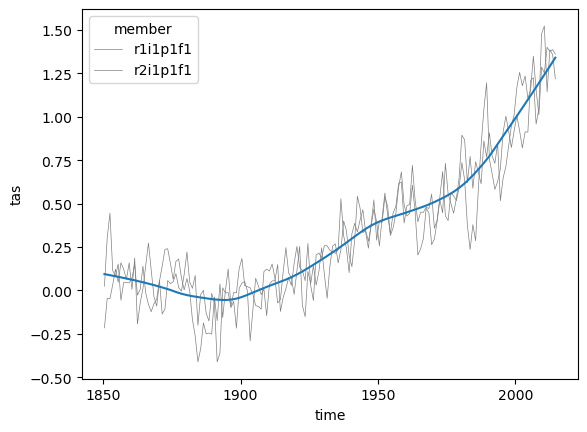

In [98]:
# plot historical
tas_globmean["historical"].tas.plot.line(x="time", color="grey", lw=0.5)
tas_globmean_smoothed["historical"].tas.plot.line(x="time")
plt.show()

2. Fit the parameter of the volcanic contributions only on the historical smoothed data of all ensemble members available. The future scenarios do not have volcanic contributions.

In [99]:
# tas_globmean_hist = tas_global_mean.sel(time=HIST_PERIOD).mean(dim="scenario")
hist_tas_residuals = tas_globmean["historical"] - tas_globmean_smoothed["historical"]

# fit volcanic influence
volcanic_params = mesmer.volc.fit_volcanic_influence(
    hist_tas_residuals.tas, hist_period=HIST_PERIOD, dim="time"
)

volcanic_params.aod

<xarray.DataArray 'aod' ()> Size: 8B
array(-1.75180901)

3. Superimpose the volcanic influence on the historical time series. Note that due to the approach to handle the historical data as its own scenario, we ecounter discontinuities at the boundary between historical and future period. However, this is not relevant for the fitting of the parameters hereafter.

In [100]:
# superimpose the volcanic forcing on historical data
tas_globmean_smoothed["historical"] = mesmer.volc.superimpose_volcanic_influence(
    tas_globmean_smoothed["historical"],
    volcanic_params,
    hist_period=HIST_PERIOD,
    dim="time",
)

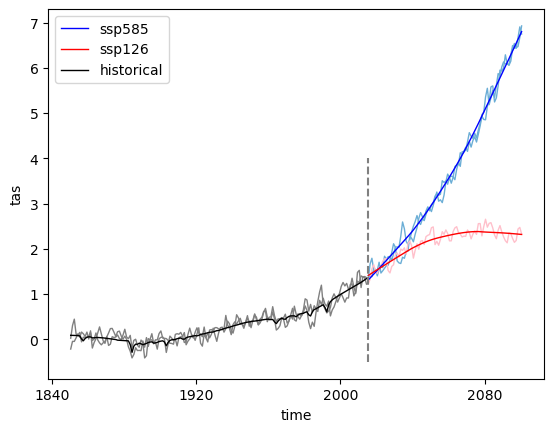

In [101]:
# some plotting
f, ax = plt.subplots()

# plot unsmoothed global means
tas_globmean["ssp585"].tas.plot.line(
    ax=ax, lw=1, x="time", color="#6baed6", add_legend=False
)
tas_globmean["ssp126"].tas.plot.line(
    ax=ax, lw=1, x="time", color="pink", add_legend=False
)
tas_globmean["historical"].tas.plot.line(
    ax=ax, lw=1, x="time", color="grey", add_legend=False
)

# plot smoothed global means including volcanic influence for historical
tas_globmean_smoothed["ssp585"].tas.plot.line(
    ax=ax, lw=1, x="time", color="blue", label="ssp585"
)
tas_globmean_smoothed["ssp126"].tas.plot.line(
    ax=ax, lw=1, x="time", color="red", label="ssp126"
)
tas_globmean_smoothed["historical"].tas.plot.line(
    ax=ax, lw=1, x="time", color="black", label="historical"
)

plt.legend()

# xmax = tas_globmean["ssp585"].time.sel(time="2020").item()
# ax.set_xlim(None, xmax)
histend = tas_globmean["ssp585"].time.sel(time="2015").item()
ax.vlines(histend, -0.5, 4.0, color="0.5", linestyle="--")
# ax.set_ylim(-0.5, 4.0)
ax.set_title("")
plt.show()

4. Calculate residuals (wrt smoothed ts) i.e. remove the smoothed global mean, including the volcanic influence from the anomalies.

In [102]:
tas_globmean_resids = tas_globmean - tas_globmean_smoothed

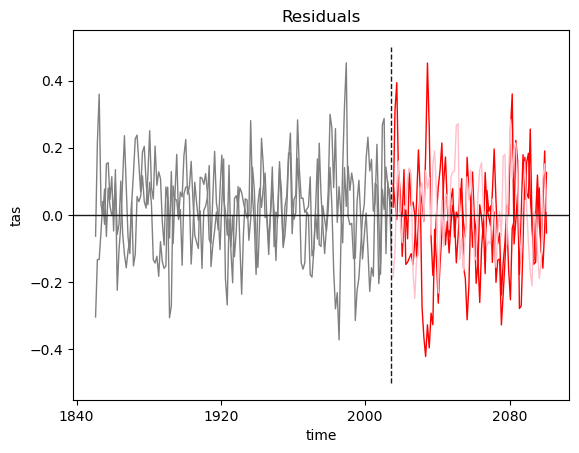

In [103]:
# plot residuals
tas_globmean_resids["ssp585"].tas.plot.line(
    x="time", color="red", lw=1, add_legend=False
)
tas_globmean_resids["ssp126"].tas.plot.line(
    x="time", color="pink", lw=1, add_legend=False
)
tas_globmean_resids["historical"].tas.plot.line(
    x="time", color="grey", lw=1, add_legend=False
)


plt.title("Residuals")
plt.axhline(0, lw=1, color="0.1")
histend = tas_globmean_resids["historical"].time.sel(time="2014").item()
plt.vlines(histend, -0.5, 0.5, color="0.1", linestyle="--", lw=1)
plt.show()
# TODO add legend for the scenarios

### Global variability

In this step we want to fit an AR process for predicting global variability, taking in the smoothed global mean temperature as follows:

$T_{t}^{glob, var} = \alpha_0 + \sum\limits_{k=1}^{k=p} \alpha_k \cdot T_{t-k}^{glob, var} + \varepsilon_t,\ \varepsilon_t \sim \mathcal{N}(0, \sigma)$

We first estimate the order of the AR process and then fit the parameters. Internally, we fit the parameters for each member and then average first over the parameters of each scenario and then over all scenarios to arrive at a single set of parameters.

In [104]:
ar_order = mesmer.stats.select_ar_order_scen_ens(
    tas_globmean_resids, dim="time", ens_dim="member", maxlag=12, ic="bic"
)

global_ar_params = mesmer.stats.fit_auto_regression_scen_ens(
    tas_globmean_resids, dim="time", ens_dim="member", lags=ar_order
)

global_ar_params.drop_vars("nobs")
# TODO: drop nobs internally, rewrite the function to work on datatrees instead of the tuple

<xarray.Dataset> Size: 32B
Dimensions:    (lags: 1)
Coordinates:
  * lags       (lags) int64 8B 1
Data variables:
    intercept  float64 8B 0.003231
    coeffs     (lags) float64 8B 0.4461
    variance   float64 8B 0.01379

### Local forced response
Now we need to estimate how the global trend translates into a local forced response. This is done using a linear regression of the global trend and the global variability as predictors:

$T_{s,t}^{resp} = \beta_s^{trend} \cdot T_t^{glob, trend} + \beta_s^{int} + \beta_s^{var} \cdot T_t^{glob, var}$

To this end, we stack all values (members, scenarios) into a single dataset, the only important thing is that predictor and predicted values stay together.

We need to prepare the local temperature data:

1. Mask out ocean grid points (where the land fraction is larger than `THRESHOLD_LAND`)
2. Mask out Antarctica
3. Convert the data from a 2D lat-lon grid to a 1D grid by stacking it and removing all gridcells that were previously masked out.



Before stacking, we extract the original grid. We need to save this together with the parameters to later be able to reconstruct the original grid from the gridpoints.

In [105]:
# extract original grid
grid_orig = tas_anoms["historical"].ds[["lat", "lon"]]

In [106]:
def mask_and_stack(ds, threshold_land):
    ds = mesmer.mask.mask_ocean_fraction(ds, threshold_land)
    ds = mesmer.mask.mask_antarctica(ds)
    ds = mesmer.grid.stack_lat_lon(ds)
    return ds


# mask and stack the data
tas_stacked = map_over_datasets(mask_and_stack, tas_anoms, THRESHOLD_LAND)

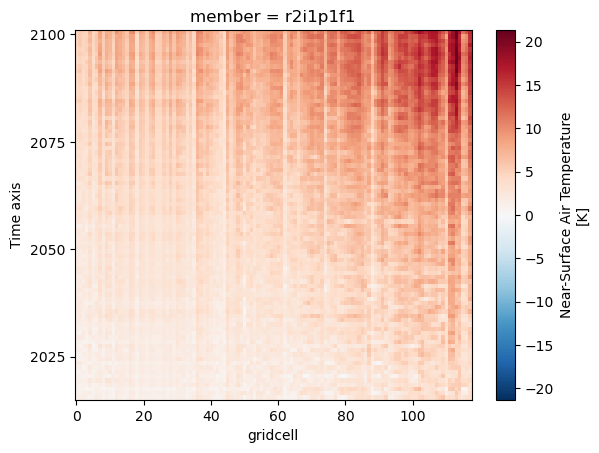

In [107]:
tas_stacked["ssp585"].tas.isel(member=1).plot()

In [108]:
# create weights
# create weights
weights = mesmer.weighted.equal_scenario_weights_from_datatree(tas_stacked)

In [109]:
predictors = xr.DataTree.from_dict(
    {"tas": tas_globmean_smoothed, "tas_resids": tas_globmean_resids}
)
# predictors["tas2"] = tas_globmean_smoothed ** 2
target = tas_stacked.copy()

In [110]:
predictors_stacked, target_stacked, weights_stacked = (
    mesmer.datatree.stack_datatrees_for_linear_regression(
        predictors, target, weights, stacking_dims=["member", "time"]
    )
)

In [111]:
local_lin_reg = mesmer.stats.LinearRegression()

local_lin_reg.fit(
    predictors=predictors_stacked,
    target=target_stacked.tas,
    dim="sample",
    weights=weights_stacked.weights,
)

local_forced_response_params = local_lin_reg.params
local_forced_response_params

<xarray.Dataset> Size: 56kB
Dimensions:        (gridcell: 118, sample: 588)
Coordinates:
    lat            (gridcell) float64 944B -49.5 -40.5 -31.5 ... 76.5 76.5 76.5
    lon            (gridcell) float64 944B 288.0 288.0 18.0 ... 324.0 342.0
    time           (sample) object 5kB 1850-07-01 06:00:00 ... 2100-07-01 06:...
    member         (sample) <U8 19kB 'r1i1p1f1' 'r1i1p1f1' ... 'r2i1p1f1'
    scenario       (sample) <U10 24kB 'historical' 'historical' ... 'ssp585'
Dimensions without coordinates: gridcell, sample
Data variables:
    intercept      (gridcell) float64 944B 0.1033 0.02489 ... 0.1346 0.09725
    tas            (gridcell) float64 944B 0.6961 0.8041 0.7246 ... 1.711 2.458
    tas_resids     (gridcell) float64 944B 0.4748 0.4167 0.4531 ... 1.674 0.692
    fit_intercept  bool 1B True
    weights        (sample) float64 5kB 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5

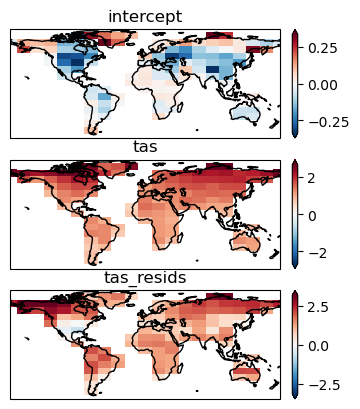

In [112]:
data_vars = (
    "intercept",
    "tas",
    "tas_resids",
)

f, axs = plt.subplots(
    3, 1, sharex=True, sharey=True, subplot_kw={"projection": ccrs.PlateCarree()}
)
axs = axs.flatten()

for ax, data_var in zip(axs, data_vars):

    da = local_forced_response_params[data_var]
    da = mesmer.grid.unstack_lat_lon_and_align(da, grid_orig)

    h = da.plot(
        ax=ax, label=data_var, robust=True, center=0, extend="both", add_colorbar=False
    )

    ax.set_extent((-180, 180, -60, 85), ccrs.PlateCarree())
    cbar = plt.colorbar(h, ax=ax, extend="both", pad=0.025)  # , shrink=0.7)
    ax.set(title=data_var, xlabel="", ylabel="", xticks=[], yticks=[])
    ax.coastlines()

### Local variability
Now we need to fit the parameters for the AR(1) process with a spatially correlated noise term used to emulate local variability:

$\eta_{s,t} = \gamma_{0, s} + \gamma_{1, 2} \cdot \eta_{s, t-1} + \nu_{s,t}, \ \nu_{s,t} \sim \mathcal{N}(0, \Sigma_{\nu}(r))$

The first component that contains the AR parameters ensures temporal correlation of the local variability whereas the noise term ensures spatial consistency. The covariance matrix is estimated on the whole grid and represents the spatial correlation of temperatures at the different gridpoints.

#### Estimate the AR parameters

First we need to compute the residuals after the linear regression:

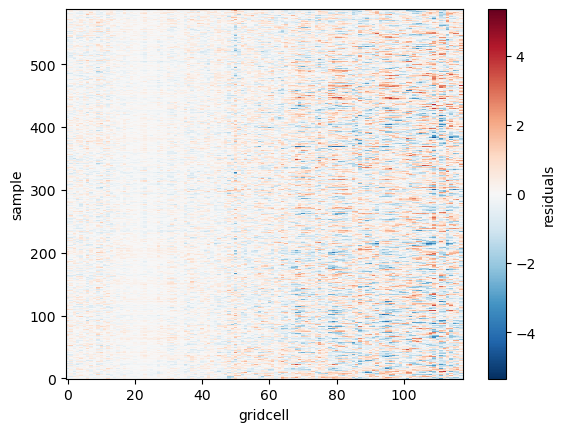

In [113]:
tas_stacked_residuals = local_lin_reg.residuals(
    predictors=predictors_stacked, target=target_stacked.tas
).T

tas_stacked_residuals.plot()

# unstack the residuals
tas_un_stacked_residuals = tas_stacked_residuals.set_index(
    sample=("time", "member", "scenario")
).unstack("sample")

In [114]:
# put each scenario into a datatree again, get rid of superfluous time steps and/or members
dt_resids = xr.DataTree()
for scenario in tas_un_stacked_residuals.scenario.values:
    dt_resids[scenario] = xr.DataTree(
        tas_un_stacked_residuals.to_dataset()
        .sel(scenario=scenario)
        .dropna("member", how="all")
        .dropna("time")
        .drop_vars("scenario")
    )

In [115]:
local_ar = mesmer.stats.fit_auto_regression_scen_ens(
    dt_resids,
    ens_dim="member",
    dim="time",
    lags=1,
)

local_ar

<xarray.Dataset> Size: 6kB
Dimensions:    (gridcell: 118, lags: 1)
Coordinates:
    lat        (gridcell) float64 944B -49.5 -40.5 -31.5 ... 76.5 76.5 76.5
    lon        (gridcell) float64 944B 288.0 288.0 18.0 ... 306.0 324.0 342.0
  * lags       (lags) int64 8B 1
Dimensions without coordinates: gridcell
Data variables:
    intercept  (gridcell) float64 944B 0.005617 -0.004653 ... 0.001156 -0.008389
    coeffs     (gridcell, lags) float64 944B 0.04742 -0.02514 ... 0.1311 0.2302
    variance   (gridcell) float64 944B 0.1496 0.1605 0.1024 ... 0.8005 0.7438
    nobs       (gridcell) float64 944B 111.3 111.3 111.3 ... 111.3 111.3 111.3

#### Estimate covariance matrix
For the covariance matrix of the white noise we first estimate the empirical covariance matrix of the gridcell's values and then localize it using the Gaspari-Cohn function. This function converges to 0 for for distances bigger than the so called localisation radius. This is also called regularization. It ensures that grid points that are further away from each other do not correlate. Such spurious correlations can arise from rank deficient covariance matrices. In our case because we estimate the covariance on data that has way more gridcells than timesteps.

The localisation radius is a parameter that needs to be calibrated and we find the best localisation radius by cross-validation of several radii using the negative loglikelihood.

1. Prepare the distance matrix - the distance between the gridpoints.

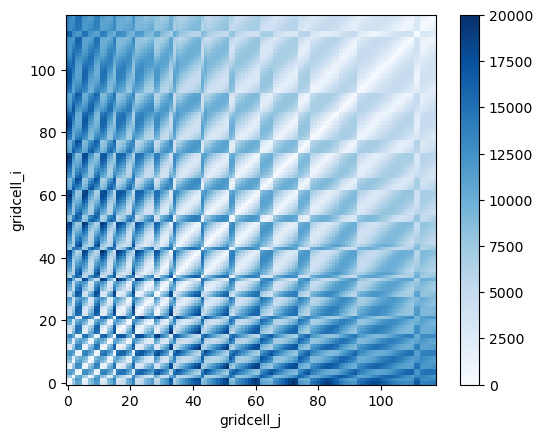

In [116]:
ds = dt_resids["historical"].ds
geodist = mesmer.geospatial.geodist_exact(ds.lon, ds.lat)

# plot
f, ax = plt.subplots()
geodist.plot(ax=ax, cmap="Blues")

ax.set_aspect("equal")

2. prepare the localizer(s) to regularize the covariance matrix

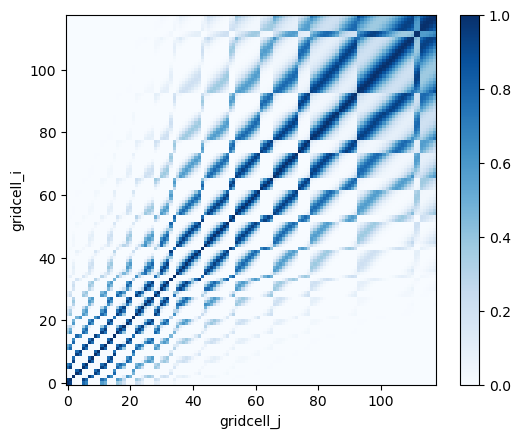

In [117]:
phi_gc_localizer = mesmer.stats.gaspari_cohn_correlation_matrices(
    geodist, range(5000, 15_001, 500)
)

# plot one
f, ax = plt.subplots()
phi_gc_localizer[5000].plot(ax=ax, cmap="Blues")

ax.set_aspect("equal")

3. Compute the weights

In [118]:
# reusing weights from local trend regression

4. find the best localization radius and localize the empirical covariance matrix

In [119]:
dim = "sample"
k_folds = 15

localized_ecov = mesmer.stats.find_localized_empirical_covariance(
    tas_stacked_residuals, weights_stacked.weights, phi_gc_localizer, dim, k_folds
)

localized_ecov

<xarray.Dataset> Size: 223kB
Dimensions:               (gridcell_i: 118, gridcell_j: 118)
Dimensions without coordinates: gridcell_i, gridcell_j
Data variables:
    localization_radius   int64 8B 13000
    covariance            (gridcell_i, gridcell_j) float64 111kB 0.1585 ... 0...
    localized_covariance  (gridcell_i, gridcell_j) float64 111kB 0.1585 ... 0...

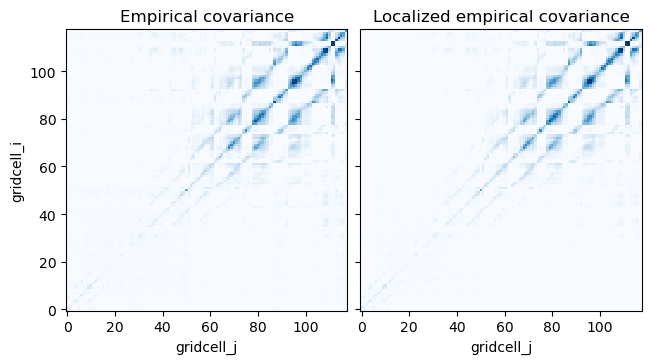

In [120]:
f, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)

opt = dict(vmin=0, vmax=1.5, cmap="Blues", add_colorbar=False)

ax = axs[0]
localized_ecov.covariance.plot(ax=ax, **opt)
ax.set_aspect("equal")
ax.set_title("Empirical covariance")

ax = axs[1]
localized_ecov.localized_covariance.plot(ax=ax, **opt)
ax.set_aspect("equal")
ax.set_title("Localized empirical covariance")
ax.set_ylabel("")
plt.show()

5. Adjust the regularized covariance matrix

Lastly we need to adjust the localized covariance matrix using the AR(1) parameters since the variance of the time series we observe is bigger than the variance of the driving white noise process. Read more about this here: "Statistical Analysis in Climate Research" by Stroch and Zwiers (1999, reprinted 2003).

In [121]:
localized_covariance_adjusted = mesmer.stats.adjust_covariance_ar1(
    localized_ecov.localized_covariance, local_ar.coeffs
)

### Saving the parameters

Finally, we have calibrated all needed parameters and can save them. We can use filefisher to nicely create file names and save the parameters.

In [122]:
param_path = data_path / "output" / "tas" / "multi_scen_multi_ens"

PARAM_FILEFINDER = FileFinder(
    path_pattern=param_path / "test-params/{module}/",
    file_pattern="params_{module}_{esm}_{scen}.nc",
)

scen_str = "-".join(scenarios)

volcanic_file = PARAM_FILEFINDER.create_full_name(
    module="volcanic",
    esm=model,
    scen=scen_str,
)
global_ar_file = PARAM_FILEFINDER.create_full_name(
    module="global-variability",
    esm=model,
    scen=scen_str,
)
local_forced_file = PARAM_FILEFINDER.create_full_name(
    module="local-trends",
    esm=model,
    scen=scen_str,
)
local_ar_file = PARAM_FILEFINDER.create_full_name(
    module="local-variability",
    esm=model,
    scen=scen_str,
)
localized_ecov_file = PARAM_FILEFINDER.create_full_name(
    module="covariance",
    esm=model,
    scen=scen_str,
)

save_files = False  # we don't save them here in the example
if save_files:
    # save the parameters
    volcanic_params.to_netcdf(volcanic_file)
    global_ar_params.to_netcdf(global_ar_file)
    local_lin_reg.to_netcdf(local_forced_file)
    local_ar.to_netcdf(local_ar_file)
    localized_ecov.to_netcdf(localized_ecov_file)

# TODO: save the original grid

We clear everything here

In [123]:
%reset -f

## Emulating near surface temperature on land

In [124]:
import importlib

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from filefisher import FileFinder

import mesmer
from mesmer.core._datatreecompat import map_over_datasets

### Load forcing data
Now one can use any global mean temperature trajectory to draw gridded realisations. For this example we want to create emulations for ssp126 and ssp585 to compare the emulations to the actual ESM output. Here we concatenate historical and future runs together to create a continuous timeseries.

In [125]:
model = "IPSL-CM6A-LR"
scenarios = ["ssp126", "ssp585"]

# some configuration parameters
THRESHOLD_LAND = 1 / 3

REFERENCE_PERIOD = slice("1850", "1900")

HIST_PERIOD = slice("1850", "2014")

In [126]:
# find the files
data_path = importlib.resources.files("mesmer").parent / "tests" / "test-data"
cmip_path = data_path / "calibrate-coarse-grid" / "cmip6-ng"

CMIP_FILEFINDER = FileFinder(
    path_pattern=cmip_path / "{variable}/{time_res}/{resolution}",
    file_pattern="{variable}_{time_res}_{model}_{scenario}_{member}_{resolution}.nc",
)

fc_scens = CMIP_FILEFINDER.find_files(
    variable="tas", scenario=scenarios, model=model, resolution="g025", time_res="ann"
)

unique_scen_members = fc_scens.df.member.unique()

fc_hist = CMIP_FILEFINDER.find_files(
    variable="tas",
    scenario="historical",
    model=model,
    resolution="g025",
    time_res="ann",
    member=unique_scen_members,
)

In [127]:
def _get_hist(meta, fc_hist):

    meta_hist = meta | {"scenario": "historical"}

    fc = fc_hist.search(**meta_hist)

    if len(fc) == 0:
        raise FileNotFoundError("no hist file found")
    if len(fc) != 1:
        raise ValueError("more than one hist file found")

    fN, meta_hist = fc[0]

    return fN, meta_hist


def load_hist(meta, fc_hist):
    fN, __ = _get_hist(meta, fc_hist)
    return xr.open_dataset(fN, use_cftime=True)


def load_hist_scen_continuous(fc_hist, fc_scens):
    dt = xr.DataTree()
    for scen in fc_scens.df.scenario.unique():
        files = fc_scens.search(scenario=scen)

        members = []

        for fN, meta in files.items():

            try:
                hist = load_hist(meta, fc_hist)
            except FileNotFoundError:
                continue

            proj = xr.open_dataset(fN, use_cftime=True)

            ds = xr.combine_by_coords(
                [hist, proj],
                combine_attrs="override",
                data_vars="minimal",
                compat="override",
                coords="minimal",
            )

            ds = ds.drop_vars(("height", "time_bnds", "file_qf"), errors="ignore")

            ds = mesmer.grid.wrap_to_180(ds)

            # assign member-ID as coordinate
            ds = ds.assign_coords({"member": meta["member"]})

            members.append(ds)

        # create a Dataset that holds each member along the member dimension
        scen_data = xr.concat(members, dim="member")
        # put the scenario dataset into the DataTree
        dt[scen] = xr.DataTree(scen_data)
    return dt

In [128]:
tas = load_hist_scen_continuous(fc_hist, fc_scens)
ref = tas.sel(time=REFERENCE_PERIOD).mean("time")
tas_anoms = tas - ref
tas_globmean = map_over_datasets(mesmer.weighted.global_mean, tas_anoms)

tas_globmean_ensmean = tas_globmean.mean(dim="member")
tas_globmean_forcing = map_over_datasets(
    mesmer.stats.lowess,
    tas_globmean_ensmean,
    kwargs={"dim": "time", "n_steps": 30, "use_coords": False},
)
time = tas_globmean_forcing["ssp126"].time

/tmp/ipykernel_71137/3673321025.py:19: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  return xr.open_dataset(fN, use_cftime=True)
/tmp/ipykernel_71137/3673321025.py:36: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  proj = xr.open_dataset(fN, use_cftime=True)
/tmp/ipykernel_71137/3673321025.py:19: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usa

### Load the parameters

In [129]:
param_path = data_path / "output" / "tas" / "multi_scen_multi_ens"

PARAM_FILEFINDER = FileFinder(
    path_pattern=param_path / "test-params/{module}/",
    file_pattern="params_{module}_{esm}_{scen}.nc",
)
scen_str = "-".join(scenarios)

In [130]:
all_modules = [
    "volcanic",
    "global-variability",
    "local-trends",
    "local-variability",
    "covariance",
]
param_files = PARAM_FILEFINDER.find_files(module=all_modules, esm=model, scen=scen_str)

params = xr.DataTree()

for module in all_modules:
    params[module] = xr.DataTree(
        xr.open_dataset(param_files.search(module=module).paths.pop()), name=module
    )

### Define seeds for global and local variability 
If we want reproducible results we need to set a seed for the random samples of global and local variability. Here, we set the seed to a chosen number, but for automated generation of seeds i.e. for several ESM we recommend using the `python-secrets` module that one can find on [pypi](https://pypi.org/project/python-secrets/). 
Then you would generate a seed using:
`xr.DataArray(secrets.randbits(64), name = "seed")`

In [131]:
seed_global_variability = xr.DataTree.from_dict(
    {
        "ssp126": xr.Dataset(data_vars={"seed": 981}),
        "ssp585": xr.Dataset(data_vars={"seed": 314}),
    }
)
seed_local_variability = xr.DataTree.from_dict(
    {
        "ssp126": xr.Dataset(data_vars={"seed": 272}),
        "ssp585": xr.Dataset(data_vars={"seed": 42}),
    }
)

### Make emulations

In [132]:
# some settings
n_realisations = 10  # 00

buffer_global_variability = 50
buffer_local_variability = 20

#### 1. Adding the volcanic influence to the smooth global mean forcing
This is optional, depending on if you want to reproduce the past accurately. This is necessary when we want to evaluate the performance of our emulator on ESM or observation data but might not be necessary for more abstract research questions.

In [133]:
tas_globmean_forcing = map_over_datasets(
    mesmer.volc.superimpose_volcanic_influence,
    tas_globmean_forcing,
    params["volcanic"].ds,
    kwargs={"hist_period": HIST_PERIOD},
)

#### 2. Compute global variabilty 
Draw samples from a AR process with the calibrated parameters.

In [134]:
global_variability = mesmer.stats.draw_auto_regression_uncorrelated(
    params["global-variability"].ds,
    realisation=n_realisations,
    time=time,
    seed=seed_global_variability,
    buffer=buffer_global_variability,
)
global_variability = map_over_datasets(
    lambda ds: ds.rename({"samples": "tas"}), global_variability
)

#### 3. Compute local forced response
Apply linear regression using the global mean forcing and the global variability as predictors. Optionally, you can also add other variables to the predictors like ocean heat content or squared global mean temperature.

In [135]:
predictors = xr.DataTree.from_dict(
    {
        "ssp126": xr.DataTree.from_dict(
            {
                "tas": tas_globmean_forcing["ssp126"],
                "tas_resids": global_variability["ssp126"],
            }
        ),
        "ssp585": xr.DataTree.from_dict(
            {
                "tas": tas_globmean_forcing["ssp585"],
                "tas_resids": global_variability["ssp585"],
            }
        ),
    }
)

lr = mesmer.stats.LinearRegression()
lr.params = params["local-trends"].ds

# uses ``exclude`` to split the linear response
local_forced_response = xr.DataTree()
local_variability_from_global_var = xr.DataTree()

for scen in predictors.children:
    # local variability part driven by global mean
    local_forced_response[scen] = xr.DataTree(
        lr.predict(predictors[scen], exclude={"tas_resids"}).rename("tas").to_dataset()
    )

    # local variability part driven by global variabilty
    local_variability_from_global_var[scen] = xr.DataTree(
        lr.predict(predictors[scen], exclude={"tas", "intercept"})
        .rename("tas")
        .to_dataset()
    )

#### 4. Compute local variability
We compute the local variability by applying an AR(1) process to ensure consistency in time and adding spatially correlated innovations at each time step to get spatially coherent random samples at each gridpoint.

In [136]:
local_variability = mesmer.stats.draw_auto_regression_correlated(
    params["local-variability"].ds,
    params["covariance"].localized_covariance,
    time=time,
    realisation=n_realisations,
    seed=seed_local_variability,
    buffer=buffer_local_variability,
)
local_variability = map_over_datasets(
    lambda ds: ds.rename({"samples": "tas"}), local_variability
)

#### 5. Add everything together

In [137]:
local_variability_total = local_variability_from_global_var + local_variability
emulations = local_forced_response + local_variability_total

### Saving emulations
We recommend saving the emulations together with the seeds used for emulating.

In [138]:
for scen in emulations:
    local_seed = seed_local_variability[scen].seed.rename("seed_local_variability")
    global_seed = seed_global_variability[scen].seed.rename("seed_global_variability")
    emulations[scen] = xr.DataTree(
        xr.merge([emulations[scen].ds, local_seed, global_seed])
    )

emu_path = data_path / "output" / "tas" / "multi_scen_multi_ens"
# emulations.to_netcdf(emu_path / f"emulations_{model}_ssp126-ssp585.nc")

## Some example plots

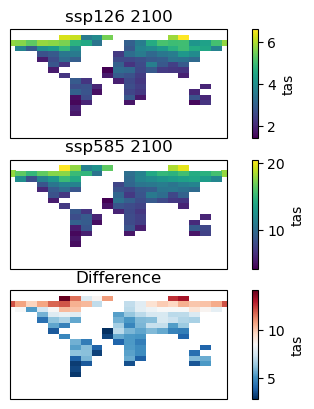

In [139]:
grid_orig = tas_anoms["ssp126"].ds[["lat", "lon"]]
spatial_emu_126 = mesmer.grid.unstack_lat_lon_and_align(
    emulations["ssp126"].tas, grid_orig
)
spatial_emu_585 = mesmer.grid.unstack_lat_lon_and_align(
    emulations["ssp585"].tas, grid_orig
)

f, axs = plt.subplots(3, 1, subplot_kw={"projection": ccrs.PlateCarree()})

spatial_emu_126.mean("realisation").sel(time="2100").plot(ax=axs[0])
spatial_emu_585.mean("realisation").sel(time="2100").plot(ax=axs[1])
(spatial_emu_585 - spatial_emu_126).mean("realisation").sel(time="2100").plot(
    ax=axs[2], cmap="RdBu_r"
)

axs[0].set_title("ssp126 2100")
axs[1].set_title("ssp585 2100")
axs[2].set_title("Difference")
plt.show()

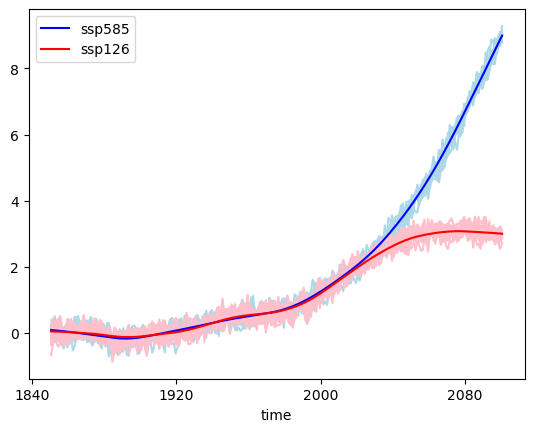

In [140]:
# plot global means
globmean_126 = mesmer.weighted.global_mean(spatial_emu_126)
globmean_585 = mesmer.weighted.global_mean(spatial_emu_585)

globmean_126_smoothed = mesmer.stats.lowess(
    globmean_126.mean("realisation"), dim="time", n_steps=50, use_coords=False
)
globmean_585_smoothed = mesmer.stats.lowess(
    globmean_585.mean("realisation"), dim="time", n_steps=50, use_coords=False
)

f, ax = plt.subplots()
globmean_585.plot.line(x="time", ax=ax, add_legend=False, color="lightblue")
globmean_126.plot.line(x="time", ax=ax, add_legend=False, color="pink")

globmean_585_smoothed.plot.line(x="time", ax=ax, color="blue", label="ssp585")
globmean_126_smoothed.plot.line(x="time", ax=ax, color="red", label="ssp126")

plt.legend()
plt.show()

In [141]:
esm_ssp585 = tas_anoms["ssp585"].ds


def mask(ds, threshold_land):
    ds = mesmer.mask.mask_ocean_fraction(ds, threshold_land)
    ds = mesmer.mask.mask_antarctica(ds)
    return ds


esm_ssp585 = mask(esm_ssp585, THRESHOLD_LAND)

In [142]:
esm_ssp585 = esm_ssp585.tas.stack(sample=("time", "lat", "lon", "member"))
emu_ssp585 = spatial_emu_585.stack(sample=("time", "lat", "lon", "realisation"))

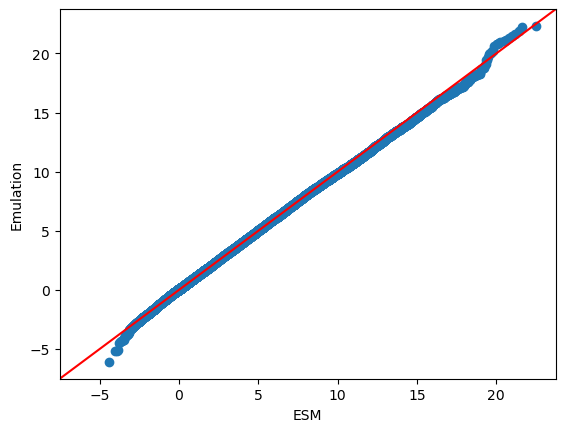

In [143]:
import statsmodels.api as sm

sm.qqplot_2samples(esm_ssp585, emu_ssp585, line="45")
plt.xlabel("ESM")
plt.ylabel("Emulation")
plt.show()